# Consommation et prix de l'électricité en France

On travaille sur une base de données "Bilan Électrique au pas demi-heure" mise à disposition par **Enedis** sur le site data.gouv.fr. 
**Enedis** est le gestionnaire de réseaux de distribution de l'électricité en France. 

De plus, on a également souhaité récupérer les données de prix de l'électricité pour pouvoir mettre en évidence la relation entre la consommation et les prix. 
Pour cela, on a récupéré sur le site **Nord Pool** qui est la plus grande bourse du marché de l'énergie en Europe, les données de prix au pas horaire. 

In [7]:
# Importation des librairies 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

sns.set_theme(style="darkgrid")


## I. Analyse de la base de données de consommation 

In [8]:
# Importation : 

path = "C:\\Users\\seren\\OneDrive\\Bureau\\M2S1\\ALGO&PYTHON\\bilan-electrique-demi-heure.csv"

df_conso = pd.read_csv(path, sep = ";")

Avant même de commencer la modélisation, nous allons procéder à une analyse de la base pour vérifier : 
    <li> La taille de la base 
    <li> Les valeurs manquantes 
    <li> Les types de variables 
    <li> Les valeurs aberrantes 

afin de s'assurer qu'elle soit exploitable.

### A. Dimension 

In [9]:
df_conso.head()

,Horodate,Mois,Injection RTE (W),Refoulement RTE (W),Pertes modélisées (W),Consommations totale (W),Consommation totale télérelevée (W),Consommation totale profilée (W),Consommation HTA profilée (W),Consommation PME-PMI profilée (W),...,Production décentralisée profilée (W),Production photovoltaïque profilée (W),Production autre profilée (W),Température réalisée lissée (°C),Température normale lissée (°C),Production éolienne totale (W),Production photovoltaïque totale (W),Pseudo rayonnement,Consommation HTA totale (W),Soutirage net vers autres GRD (W)
0,2020-10-20T09:30:00+02:00,10,4.289583e+10,4.076520e+09,2.998834e+09,4.493303e+10,1.464271e+10,3.029032e+10,1.865798e+09,7.575023e+09,...,239647744.0,224980221.0,3660903.0,11.2,12.2,7.695118e+09,5.149727e+08,11.0,1.650851e+10,330019373.0
1,2020-10-20T12:00:00+02:00,10,4.333602e+10,4.265215e+09,3.125184e+09,4.627304e+10,1.419591e+10,3.207713e+10,1.706854e+09,6.773464e+09,...,730574337.0,716023537.0,3660903.0,12.4,13.1,7.687336e+09,1.716482e+09,7.0,1.590277e+10,317024982.0
2,2020-10-20T17:30:00+02:00,10,3.805279e+10,4.231954e+09,2.631003e+09,4.010122e+10,1.286971e+10,2.723151e+10,1.561773e+09,5.973193e+09,...,157270318.0,142345156.0,3660903.0,13.5,14.2,7.652356e+09,3.085066e+08,3.0,1.443149e+10,275383290.0
3,2020-10-21T01:00:00+02:00,10,3.303353e+10,3.963927e+09,2.239883e+09,3.465815e+10,1.022670e+10,2.443145e+10,1.140185e+09,3.539265e+09,...,13418778.0,55140.0,3568844.0,12.8,12.4,6.942612e+09,8.307730e+05,4.0,1.136689e+10,256012359.0
4,2020-10-21T01:30:00+02:00,10,3.252284e+10,4.173912e+09,2.222280e+09,3.418453e+10,1.019306e+10,2.399147e+10,1.131348e+09,3.483127e+09,...,13391071.0,91577.0,3568844.0,12.8,12.4,7.144654e+09,8.689600e+05,4.0,1.132441e+10,239817132.0


On se rend compte ici que les données de date ne sont pas ordonnées.

In [10]:
df_conso = df_conso.sort_values(by=['Horodate'])

In [11]:
df_conso.shape

(87648, 24)

In [12]:
df_conso.columns

Index(['Horodate', 'Mois', 'Injection RTE (W)', 'Refoulement RTE (W)',
       'Pertes modélisées (W)', 'Consommations totale (W)',
       'Consommation totale télérelevée (W)',
       'Consommation totale profilée (W)', 'Consommation HTA profilée (W)',
       'Consommation PME-PMI profilée (W)',
       'Consommation professionnelle profilée (W)',
       'Consommation résidentielle profilée (W)',
       'Production décentralisée totale (W)',
       'Production décentralisée télérelevée à courbe de charge (W)',
       'Production décentralisée profilée (W)',
       'Production photovoltaïque profilée (W)',
       'Production autre profilée (W)', 'Température réalisée lissée (°C)',
       'Température normale lissée (°C)', 'Production éolienne totale (W)',
       'Production photovoltaïque totale (W)', 'Pseudo rayonnement',
       'Consommation HTA totale (W)', 'Soutirage net vers autres GRD (W)'],
      dtype='object')

La base de données comportant les données de consommation possède donc `87 648` observations pour `24` variables : 
    <li> `horodate`: La date au pas de demi-horaire
    <li> `Mois`
    <li> `Injection RTE (W)` : RTE est le gestionnaire de réseaux de transport de l'électricité en France. Cette variable quantifie donc la quantité d'électricité injecté sur le réseaux en Watt
    <li> `Refoulement RTE (W)` 
    <li> `Pertes modélisées (W)` : Cette variable représente la perte d'électricité subit sur le réseaux. Elles sont calculées par un polynôme de type A.P² + B.P + C, avec P la puissance et A,B,C des coefficients réévaluées chaque année. 
    <li> `Consommations totale, télérelevée et profilée (W)` : télérelevée signifie que la consommateur dispose d'un compteur qui calcule en temps réel la consommation, ceux qui ne disposent pas d'un tel compteur sont donc des profilés : leur consommation est estimée selon leur profil et celle-ci dépend alors de la température et de la conjoncture actuelle. 
    <li> `Consommation HTA` : représente les consommateurs dits à Haute Tension. 
    <li> `Consommation PME-PMI, professionelle` : consommations des professionnels, PME-PMI représentant les petites et moyennes entreprises. 
    <li> `Consommation résidentielle` représente donc celle des particuliers 
    <li> `Production décentralisée` représente la production d'électricité d'installation de petite capacité.
            

### B. Valeurs manquantes et types de variables 

In [13]:
Nom_Var = df_conso.columns
def var(nomvar,data):
    print("Nom de la var : " + nomvar)
    print(f"Nombre de modalités : {data[nomvar].nunique()}")
    print(f"Vecteurs des modalités : {data[nomvar].unique()}")
    print(f"Counts en chaque modalités : {data[nomvar].value_counts()}")
    print(data[nomvar].describe())
    print(f"La colonne a {data[nomvar].isna().sum()}  valeur(s) manquante(s)")
    print(f"La variable admet donc {(data[nomvar].isna().sum()/len(data))*100} % de valeur(s) manquante(s)")
    
def num_missing(x):
    return sum(x.isnull())

In [14]:
for i in Nom_Var : 
    print(var(i,df_conso))

Nom de la var : Horodate
Nombre de modalités : 87648
Vecteurs des modalités : ['2016-10-23T00:00:00+02:00' '2016-10-23T00:30:00+02:00'
 '2016-10-23T01:00:00+02:00' ... '2021-10-22T22:30:00+02:00'
 '2021-10-22T23:00:00+02:00' '2021-10-22T23:30:00+02:00']
Counts en chaque modalités : 2021-03-19T21:00:00+01:00    1
2017-01-05T18:30:00+01:00    1
2021-09-01T20:30:00+02:00    1
2016-11-02T16:30:00+01:00    1
2017-11-04T23:30:00+01:00    1
                            ..
2021-02-06T16:00:00+01:00    1
2019-08-08T14:30:00+02:00    1
2016-12-08T23:30:00+01:00    1
2020-02-25T21:30:00+01:00    1
2021-08-29T18:30:00+02:00    1
Name: Horodate, Length: 87648, dtype: int64
count                         87648
unique                        87648
top       2021-03-19T21:00:00+01:00
freq                              1
Name: Horodate, dtype: object
La colonne a 0  valeur(s) manquante(s)
La variable admet donc 0.0 % de valeur(s) manquante(s)
None
Nom de la var : Mois
Nombre de modalités : 12
Vecteurs des 

Nombre de modalités : 87648
Vecteurs des modalités : [2.85236818e+09 2.83140113e+09 2.81030798e+09 ... 2.93853341e+09
 2.84792509e+09 2.74747591e+09]
Counts en chaque modalités : 4.589143e+09    1
4.648146e+09    1
9.296115e+09    1
3.397773e+09    1
5.721831e+09    1
               ..
3.576559e+09    1
7.153124e+09    1
1.215878e+10    1
8.226889e+09    1
3.416642e+09    1
Name: Production décentralisée totale (W), Length: 87648, dtype: int64
count    8.764800e+04
mean     6.186752e+09
std      3.172313e+09
min      9.533395e+08
25%      3.794008e+09
50%      5.578405e+09
75%      7.968309e+09
max      2.100947e+10
Name: Production décentralisée totale (W), dtype: float64
La colonne a 0  valeur(s) manquante(s)
La variable admet donc 0.0 % de valeur(s) manquante(s)
None
Nom de la var : Production décentralisée télérelevée à courbe de charge (W)
Nombre de modalités : 87632
Vecteurs des modalités : [2.84248567e+09 2.82153800e+09 2.80048500e+09 ... 2.93389670e+09
 2.84328802e+09 2.7428341

count    8.764800e+04
mean     3.146301e+09
std      2.519895e+09
min      3.825433e+07
25%      1.237835e+09
50%      2.352131e+09
75%      4.391161e+09
max      1.292551e+10
Name: Production éolienne totale (W), dtype: float64
La colonne a 0  valeur(s) manquante(s)
La variable admet donc 0.0 % de valeur(s) manquante(s)
None
Nom de la var : Production photovoltaïque totale (W)
Nombre de modalités : 65221
Vecteurs des modalités : [  25333.   24667.   22000. ... 2721026. 1982186. 2007299.]
Counts en chaque modalités : 2.733300e+04    580
2.766700e+04    568
2.666700e+04    557
2.633300e+04    555
2.700000e+04    547
               ... 
1.518825e+09      1
1.483223e+06      1
1.562978e+08      1
8.726810e+05      1
1.310721e+06      1
Name: Production photovoltaïque totale (W), Length: 65221, dtype: int64
count    8.764800e+04
mean     1.159086e+09
std      1.701188e+09
min     -6.045000e+06
25%      4.892430e+05
50%      4.113889e+07
75%      2.013317e+09
max      9.142793e+09
Name: Pro

In [15]:
print("Valeurs manquantes par colonne:")
print(df_conso.apply(num_missing, axis=0)) 

Valeurs manquantes par colonne:
Horodate                                                          0
Mois                                                              0
Injection RTE (W)                                                 0
Refoulement RTE (W)                                               0
Pertes modélisées (W)                                             0
Consommations totale (W)                                          0
Consommation totale télérelevée (W)                               0
Consommation totale profilée (W)                                  0
Consommation HTA profilée (W)                                     0
Consommation PME-PMI profilée (W)                                 0
Consommation professionnelle profilée (W)                         0
Consommation résidentielle profilée (W)                           0
Production décentralisée totale (W)                               0
Production décentralisée télérelevée à courbe de charge (W)       0
Production décen

On voit donc que seule la variable `Pseudo rayonnement` admet des valeurs manquantes pour un total de 8%. 
En raison du nombre de valeurs manquantes et du fait que seule cette variable en admette, on décide de la supprimer.
On aurait pu essayer de modéliser cette variable pour voir si elle admettait une saisonnalité pour pouvoir estimer les valeurs manquantes. Cependant, le calcul de cette variable est trop complexe pour ce genre de modélisation. 

On observe également que toutes nos variables sont numériques. C'est également le cas de la variable de date, on décide donc de la mettre au format date 

In [16]:
df_conso.drop(columns = ["Pseudo rayonnement"], inplace = True)
df_conso["Horodate"] = pd.to_datetime(df_conso["Horodate"])

## II. Analyse de la base de données des prix 

La base de données qu'on avait à notre disposition jusque là était complète, mais il manquait une variable importante pour notre analyse : **le prix de l'électricité**. 
On a donc récupéré une autre base avec les prix au pas horaire. 
Sur le site de la bourse du marché de l'énergie, on a pu récupérer un fichier excel par année. 
On a donc dû les importer et les concaténer. 

### A. Importation et traitement 

In [17]:
dossiers = { 'data' : [2016,2022]}

dfs = []
k = 'data'
for i in range(dossiers[k][0],dossiers[k][1]):
    try:
        dfs.append(pd.read_excel(r'C:\\Users\\seren\\OneDrive\\Bureau\\M2S1\\ALGO&PYTHON\\{}\\{}.xlsx'.format(k,i)))
    except:
        pass
ganisland = pd.concat(dfs)
df_price = ganisland.reset_index()

df_price.drop(columns = ["index"], inplace = True)


In [18]:
df_price.head(10)

,Date,Hours,Prix
0,2016-01-01,00:00:00,16.39
1,2016-01-01,01:00:00,16.04
2,2016-01-01,02:00:00,15.74
3,2016-01-01,03:00:00,15.57
4,2016-01-01,04:00:00,15.47
5,2016-01-01,05:00:00,15.75
6,2016-01-01,06:00:00,15.36
7,2016-01-01,07:00:00,15.37
8,2016-01-01,08:00:00,15.19
9,2016-01-01,09:00:00,15.39


Le dataframe contient donc `51 366` observations et `3` variables. 
Cependant, on ne peut pas concaténer directement ce dataframe avec celui des consommations car d'une part celui-ci est au pas horaire et non demi-horaire, et d'autre part la période de temps n'est pas la même. 
On décide donc de travailler au pas horaire. 

In [19]:
# On garde seulement les heures entières de la base de consommation
minutes = df_conso[df_conso['Horodate'].astype(str).str.contains(':30:')].index
df_conso.drop(minutes,0, inplace=True)

# On récupère la période qui nous intéresse 
df_price = df_price[(df_price["Date"] >= "2016-10-23") & (df_price["Date"] <= "2021-10-22" )]

In [20]:
print("Valeurs manquantes par colonne:")
print(df_price.apply(num_missing, axis=0)) 

Valeurs manquantes par colonne:
Date     0
Hours    0
Prix     5
dtype: int64


In [21]:
df_price.shape

(43829, 3)

### B. Concaténation avec la base de consommation

In [22]:
#Pour trouver les lignes qu'il y a en trop.
#On regarde quelle heure apparait plus que les autre
#On trouve qu'il y a 1831 minuit alors que pour les autres valeurs il n'y en a que 1826
df_price[df_price['Hours'].astype(str).str.contains('00:00:00')].count
df_conso[df_conso['Horodate'].astype(str).str.contains('T00:00:00')].count

<bound method DataFrame.count of Empty DataFrame
Columns: [Horodate, Mois, Injection RTE (W), Refoulement RTE (W), Pertes modélisées (W), Consommations totale (W), Consommation totale télérelevée (W), Consommation totale profilée (W), Consommation HTA profilée (W), Consommation PME-PMI profilée (W), Consommation professionnelle profilée (W), Consommation résidentielle profilée (W), Production décentralisée totale (W), Production décentralisée télérelevée à courbe de charge (W), Production décentralisée profilée (W), Production photovoltaïque profilée (W), Production autre profilée (W), Température réalisée lissée (°C), Température normale lissée (°C), Production éolienne totale (W), Production photovoltaïque totale (W), Consommation HTA totale (W), Soutirage net vers autres GRD (W)]
Index: []

[0 rows x 23 columns]>

On se rend compte que même au même pas de temps, et avec la même période, il y a 5 observations en trop dans le dataframe des prix. 
En faisant des analyses sur les valeurs manquantes, on se rend compte que la variable Prix admet exactement 5 valeurs manquantes. En cherchant plus loin on voit que cela correspondait à des occurences de l'heure 00h. On décide donc de supprimer ces lignes pour ensuite pouvoir concaténer les deux dataframes.

In [23]:
#Pour supprimer les lignes en trop avec un nan dans la colonne prix
index_with_nan = df_price.index[df_price["Prix"].isnull()]
df_price.drop(index_with_nan,0, inplace=True)

#Suppression colonnes dans df5 pour qu'il ne reste que les prix
df_price = df_price.drop(['Hours', 'Date'], 1) 


#Remettre l'index à 0
df_conso = df_conso.reset_index(drop=False, inplace=False)
df_price = df_price.reset_index(drop=False, inplace=False)


#On concatène les deux fichiers
df_final = df_conso.merge(df_price, how='inner', left_index=True, right_index=True)

In [24]:
df_final.head()

,index_x,Horodate,Mois,Injection RTE (W),Refoulement RTE (W),Pertes modélisées (W),Consommations totale (W),Consommation totale télérelevée (W),Consommation totale profilée (W),Consommation HTA profilée (W),...,Production photovoltaïque profilée (W),Production autre profilée (W),Température réalisée lissée (°C),Température normale lissée (°C),Production éolienne totale (W),Production photovoltaïque totale (W),Consommation HTA totale (W),Soutirage net vers autres GRD (W),index_y,Prix
0,53530,2016-10-23 00:00:00+02:00,10,4.063966e+10,8.054930e+08,3.339653e+09,3.890665e+10,8.034015e+09,3.087264e+10,907017939.0,...,0.0,72142.0,9.8,12.2,2.101485e+09,25333.0,8.941033e+09,440226697.0,7104,33.09
1,29018,2016-10-23 01:00:00+02:00,10,3.717426e+10,8.599010e+08,2.990955e+09,3.573062e+10,7.934251e+09,2.779637e+10,869330351.0,...,0.0,72142.0,9.8,12.2,2.067500e+09,22000.0,8.803581e+09,403091526.0,7105,32.69
2,53531,2016-10-23 02:00:00+02:00,10,3.593819e+10,8.620720e+08,2.869121e+09,3.465796e+10,7.864872e+09,2.679309e+10,822502905.0,...,0.0,72142.0,9.7,12.1,2.098960e+09,22000.0,8.687375e+09,388068636.0,7106,32.41
3,38732,2016-10-23 03:00:00+02:00,10,3.292863e+10,9.200830e+08,2.578077e+09,3.195787e+10,7.853917e+09,2.410395e+10,818450322.0,...,0.0,72142.0,9.7,12.1,2.129551e+09,25000.0,8.672367e+09,348244654.0,7107,31.85
4,77655,2016-10-23 04:00:00+02:00,10,3.116248e+10,1.062332e+09,2.410971e+09,3.041073e+10,7.828469e+09,2.258226e+10,828305185.0,...,0.0,72142.0,9.6,12.0,2.293851e+09,22000.0,8.656774e+09,328433517.0,7108,32.03


In [25]:
df_final.drop(columns = ["index_x","index_y"], inplace = True)

## III. Analyse de la série chronologique 

Nous allons dans cette partie tenter de visualiser graphiquement la série, afin de dégager les différentes composantes :
    <li> Une tendance 
    <li> Une saisonnalité 
    <li> Un bruit 
        
Par intuition, on suppose que la série admet au moins trois types de saisonnalité :
     <li> Une saisonnalité **journalière** : en fonction du moment de la journée, la consommation électrique n'est pas la même.
     <li> Une saisonnalité **hebdomadaire** : la consommation peut dépendre du jour de la semaine, en effet on imagine qu'une ménage consomme plus le week-end par exemple.
     <li> Une saisonnalité **mensuelle** : en effet, la consommation d'électricité fluctue en fonction du mois de l'année. On suppose qu'elle est plus elevée en hiver par rapport à l'été. 
 
 
        
En revanche, il convient de distinguer la consommation des professionnels et celle des particuliers. En effet, on s'attend à ce que la première soit plus importante en journée (durant les heures de travail), tandis que celle des particuliers doit atteindre un pic le matin ainsi qu'en soirée, et être plutôt faible la journée. 

Avant toute chose, on commence par faire un simple graphique de la consommation d'électricité totale. 

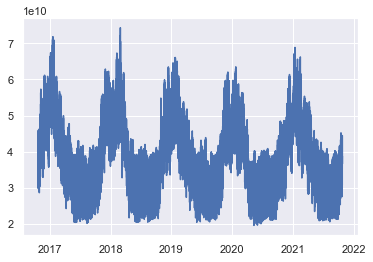

In [26]:
plt.plot(df_final["Horodate"], df_final["Consommations totale (W)"]) ; 

Conformément à notre intuition, on remarque tout de suite la tendance de la consommation : on imagine que les pics de consommation sont atteints en hiver, et qu'au contraire, les moments où la consommation est minimale correspond aux mois d'été. 
On remarque également des oscillations locales : on suppose que celles-ci sont le fruit des deux autres saisonnalités. 

Pour faciliter la suite de l'analyse, nous allons créer 4 nouvelles variables : 
`year`, `hours`, `weekday` et `Date` 

In [27]:
# On créé une nouvelle variable Year 
df_final.insert(1, 'Year',df_final["Horodate"].astype(str).str[:4] )

# On créé une nouvelle variable Hours 
df_final.insert(2, 'Hours',df_final["Horodate"].astype(str).str[11:13] )

df_final["weekday"] = df_final["Horodate"].apply(lambda x: x.weekday())

df_final["Date"] = df_final["Horodate"].astype(str).str[:10]

### A. Une saisonnalité horaire 

Puisque l'on dispose de nos données au pas horaire, l'analyse de cette saisonnalité ne nécessite pas de traitement particulier sur le dataframe 

On commence par faire le graphique d'un jour pris au hasard  

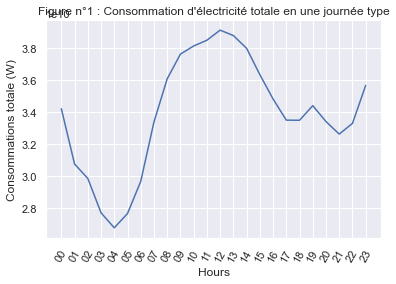

In [33]:
df_day = df_final[df_final["Date"] == "2019-05-29"]

sns.lineplot(x = "Hours", y = "Consommations totale (W)",
             data = df_day
             
             )
plt.title("Figure n°1 : Consommation d'électricité totale en une journée type")
plt.xticks(rotation = 60);

On voit qu'un pic de consommation a lieu en milieu de journée, puis un second en début de soirée. 
Cela est conforme également à ce qu'on peut attendre : la nuit la consommation est presque nulle, puis elle augmente le matin et en fin de journée. 
De plus, la base regroupe les consommations de professionnelles et également de particuliers : les premiers consomment donc la journée pour leur activité, et les dernier consomment plutôt en fin de journée/début de soirée. 
On peut aisément vérifier cela séparant les deux consommations. 
On voit donc l'intéret ici de distinguer les deux consommations, puisque les comportements sont à l'opposé : le pic de consommation des professionels est atteint en journée, tandis que celle des particuliers en fin de journée/début de soirée. 

Nous souhaitons maintenant faire un graphique qui permet de mettre en évidence si on retrouve ce même pattern de consommation pour plusieurs jours. On décide ainsi de sélectionner un jour par saison pour également mettre en lumière les différences de niveau de consommation. 

<div class="alert alert-danger">
    <b>JARRIVE PAS A METTRE LA MEME ECHELLE : IL FAUDRAIT QUE CA RENDE COMME DANS LE PDF DU MEMOIRE QUE J'AI MIS EN ARTICLE</b> 
    
</div>

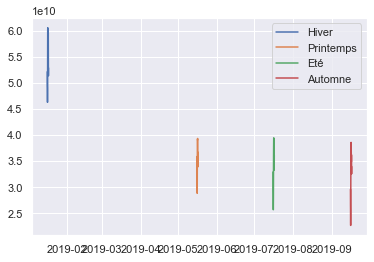

In [36]:
df_hiver = df_final.loc[df_final["Date"] == "2019-01-16"]
df_print = df_final.loc[df_final["Date"] == "2019-05-16"]
df_ete = df_final.loc[df_final["Date"] == "2019-07-16"] 

df_automn = df_final.loc[df_final["Date"] == "2019-09-16"]

plt.plot(df_hiver["Horodate"], df_hiver["Consommations totale (W)"],
        label = "Hiver") 
plt.plot(df_print["Horodate"], df_print["Consommations totale (W)"],
        label ="Printemps")
plt.plot(df_ete["Horodate"], df_ete["Consommations totale (W)"],
        label = "Eté")
plt.plot(df_automn["Horodate"], df_automn["Consommations totale (W)"],
        label = "Automne")
plt.legend(); 

BLABLABLA COMMENTER LE GRAPHIQUE 

On décide de comparer maintenant la consommation des professionnels et celle des particuliers pour voir si cela est intéressant de distinguer ces deux types de consommateurs 

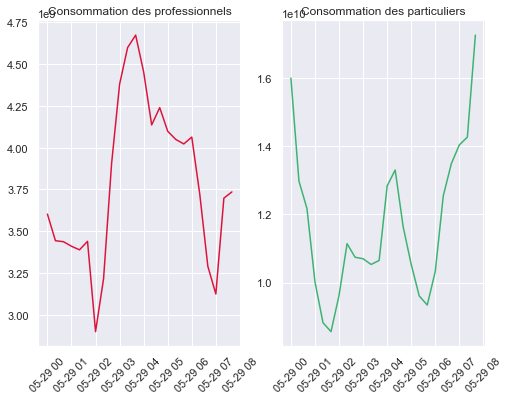

In [34]:
fig, [ax1, ax2]= plt.subplots(1, 2, figsize=(8, 6))

ax1.set_title("Consommation des professionnels")
ax1.plot(df_day["Horodate"], df_day["Consommation professionnelle profilée (W)"],
        color = 'crimson')
ax1.set_xticklabels(df_day["Horodate"].astype(str).str[5:13], rotation=45)

ax2.set_title("Consommation des particuliers")
ax2.plot(df_day["Horodate"], df_day["Consommation résidentielle profilée (W)"],
        color = 'mediumseagreen') 
ax2.set_xticklabels(df_day["Horodate"].astype(str).str[5:13], rotation=45);

On voit donc l'intéret ici de distinguer les deux consommations, puisque les comportements sont à l'opposé : le pic de consommation des professionels est atteint en journée, tandis que celle des particuliers en fin de journée/début de soirée. 

**1. Consommation des particuliers**

In [37]:
var_tokeep = ["Horodate","Consommation résidentielle profilée (W)"]
Conso_elec = df_final[var_tokeep]
Conso_elec.set_index("Horodate", inplace = True)

rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(Conso_elec, model='additive', period = 8760) 
# Période de 1 an donc 365 x 24 car données au pas horaire
fig = decomposition.plot()
plt.show()

NameError: name 'rcParams' is not defined

**2. Consommation des professionnels**

In [ ]:
var_tokeep = ["Horodate","Consommation professionnelle profilée (W)"]
Conso_elec = df_final[var_tokeep]
Conso_elec.set_index("Horodate", inplace = True)

rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(Conso_elec, model='additive', period = 8760) 
# Période de 1 an donc 365 x 24 car données au pas horaire
fig = decomposition.plot()
plt.show()

### B. Une saisonnalité hebdomadaire

La seconde saisonnalité à laquelle on s'attend est donc celle hebdomadaire. Cela signifie qu'on doit retrouver les mêmes variations de consommation selon les jours de la semaine. 

In [ ]:
sns.lineplot(x = "weekday", 
            y = "Consommations totale (W)",
            data = df_final) ;

0 correspondant au lundi, on voit que notre intuition était éronnée : la consommation électrique est plus élevée la semaine, et décroit le week-end. Cependant, cela est vraie pour la consommation totale, on peut refaire l'analyse en différenciants les professionnels et les particuliers. 

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:red'

#bar plot creation
ax1.set_title('Consommation des professionnels et des particuliers', fontsize=16)
ax1.set_xlabel('Weekday', fontsize=16)
ax1.set_ylabel('Consommation des professionnels', fontsize=16)
ax1 = sns.lineplot(x = "weekday", 
            y = "Consommation professionnelle profilée (W)",
            data = df_final,
            color = 'crimson') ; 
ax1.tick_params(axis='y', color = color)

#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:green'

#line plot creation
ax2.set_ylabel('Consommation des particuliers%', fontsize=16)
ax2 = sns.lineplot(x = "weekday", 
            y = "Consommation résidentielle profilée (W)",
            data = df_final,
            color = 'mediumseagreen') ; 
ax2.tick_params(axis='y', color = color)
sns.lineplot(x = "weekday", 
            y = "Consommation résidentielle profilée (W)",
            data = df_final) ; 

#show plot
plt.show()

On observe donc que notre intuition était vraie en ce qui concerne les particuliers : la consommation est plus importante en weekend que pendant la semaine. Pour les professionels, c'est l'inverse. On a un effet presque symmétrique entre ces deux groupes. 

Pour pouvoir véritablement entrer dans l'analyse de la saisonnalité, nous devons nous ramener à une série à pas journalier. 
On décide donc pour cela d'utiliser la moyenne de consommation au cours de la journée. 

In [ ]:
df_journalier = df_final.pivot_table(values='Consommations totale (W)',
                                             #,"Consommation résidentielle profilée (W)" ,
                                             #"Consommation professionnelle profilée (W)"],
           # index='year',
            columns='Date',
            aggfunc='mean') # par défaut : mean
df_journalier = df_journalier.transpose()
df_journalier

In [ ]:
rcParams['figure.figsize'] = 11, 9 

decomposition = sm.tsa.seasonal_decompose(df_journalier, model='additive', period = 364) 
fig = decomposition.plot()
plt.show()

**1. Consommation des particuliers**

In [ ]:
df_journalier_part = df_final.pivot_table(values='Consommation résidentielle profilée (W)',
                                             #,"Consommation résidentielle profilée (W)" ,
                                             #"Consommation professionnelle profilée (W)"],
           # index='year',
            columns='Date',
            aggfunc='mean') # par défaut : mean
df_journalier_part = df_journalier.transpose()
df_journalier_part

rcParams['figure.figsize'] = 11, 9 

decomposition = sm.tsa.seasonal_decompose(df_journalier_part, model='additive', period = 364) 
fig = decomposition.plot()
plt.show()

**2. Consommation des professionnels**

In [ ]:
df_journalier_pro = df_final.pivot_table(values='Consommation professionnelle profilée (W)',
                                             #,"Consommation résidentielle profilée (W)" ,
                                             #"Consommation professionnelle profilée (W)"],
           # index='year',
            columns='Date',
            aggfunc='mean') # par défaut : mean
df_journalier_pro = df_journalier.transpose()
df_journalier_pro

rcParams['figure.figsize'] = 11, 9 

decomposition = sm.tsa.seasonal_decompose(df_journalier_pro, model='additive', period = 364) 
fig = decomposition.plot()
plt.show()

### C. Une saisonnalité mensuelle 

<div class="alert alert-success">
    
<b>TRES EASY POUR CREER LA TABLE : IL FAUT CREER UNE NOUVELLE VARIABLE DU TYPE "ANNEE - JOUR" (on peut la créer directement là où on a créé les autres variables (year, hours ect ...). Puis faire la même chose avec pivot_table mais avec cette variable à la place de la variable Date</b>
</div>

**1. Consommation des particuliers**

**2. Consommation des professionnels**